In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm

To simulate infinte systems, we must feed the solver with a Hamiltonian evaluated on a k-point grid. The nd-array must be ordered as `[k_x, ..., k_n, i, j]` where (`k_x`, ..., `k_n`) is a k-point and `i` and `j` are orbital degrees of freedom.

We exemplify by computing the groundstate of an infinite spinfull chain with onsite interactions.

Because the groundstate is an antiferromagnet, we must build a two-atom cell. Thus, the cell contain two sublattices, $A$ and $B$. and the Hamiltonian in momentum space takes the form:
$$
H_0(k) = \left(c_A(k)^{\dagger}~c_B(k)^{\dagger}\right) \left(\begin{array}{cc}
    0 & 1 + e^{ik}\\
    1 + e^{-ik} & 0
\end{array}\right)
\left(\begin{array}{c}
    c_A(k)\\
    c_B(k)
\end{array}\right)~.
$$
We write down the spinful by simply taking $H_0(k) \otimes \mathbb{1}$.

In [2]:
def hamiltonian(k):
    tk = (1 + np.exp(1j * k)) * np.eye(2)
    return np.block([
        [0 * np.eye(2), tk],
        [tk.conj(), 0 * np.eye(2)]
    ])

To build the tight-binding model, we need to generate a Hamiltonian on a k-point and the corresponding hopping vectors to generate a guess. We then verify the spectrum and see that the bands indeed consistent of two bands due to the Brillouin zone folding.

In [3]:
# Compute non-interacting Hamiltonian on a coarse k-point grid
# Number of k-points along each direction
nk = 50
# k-points must start at zero
ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
hamiltonians_0 = np.array([hamiltonian(k) for k in ks])
hopping_vecs = np.array([[0,], [1,], [-1,]])

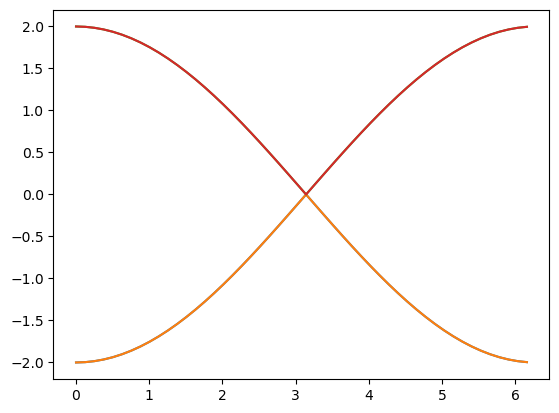

In [4]:
vals, vecs = np.linalg.eigh(hamiltonians_0)
plt.plot(ks, vals)
plt.show()

Here, in the workflow to find the groundstate, we use a helper function to build the initial guess.

In [5]:
def compute_gap(
    H_int,
    ks,
    ks_dense,
    hamiltonians_0=hamiltonians_0,
    filling=2,
    tol=1e-5,
    mixing=0.01,
    order=10,
    guess=None
):
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess(ks, hopping_vecs, ndof=hamiltonians_0.shape[-1], scale=1)
    else:
        guess += np.max(guess) * utils.generate_guess(ks, hopping_vecs, ndof=hamiltonians_0.shape[-1], scale=0.1)

    # Find groundstate Hamiltonian on the same grid
    hk = hf.find_groundstate_ham(
        H_int=H_int,
        filling=filling,
        hamiltonians_0=hamiltonians_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(hk)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, vals - E_F

Finally, we compute the eigen0alues for a set of Ualues of $U$. For this case, since the interaction is onsite only, the interaction matrix is simply
$$
H_{int} =
\left(\begin{array}{cccc}
    U & U & 0 & 0\\
    U & U & 0 & 0\\
    0 & 0 & U & U\\
    0 & 0 & U & U
\end{array}\right)~.
$$

In [6]:
def compute_phase_diagram(
    Us,
    ks,
    tol=1e-6,
    mixing=0.01,
    order=10,
):
    # onsite interactions
    v_int = np.block(
        [[np.ones((2, 2)), np.zeros((2, 2))], [np.zeros((2, 2)), np.ones((2, 2))]]
    )
    v_int = np.array([v_int for k in ks])
    gap = []
    vals = []
    for U in tqdm(Us):
        H_int = U * v_int
        _gap, _vals = compute_gap(
            H_int=H_int,
            ks=ks,
            ks_dense=ks_dense,
            tol=tol,
            mixing=mixing,
            order=order,
        )
        gap.append(_gap)
        vals.append(_vals)
    return np.asarray(gap, dtype=float), np.asarray(vals)

In [14]:
# Interaction strengths
Us = np.linspace(0, 3, 20, endpoint=True)
gap, vals = compute_phase_diagram(Us, ks=ks)

100%|██████████| 20/20 [00:01<00:00, 16.20it/s]


In [15]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(
        vals=(["Us", "ks", "n"], vals),
        gap=(["Us"], gap)
    ),
    coords=dict(Us=Us, ks=ks, n=np.arange(vals.shape[-1])),
)

We observe that as the interaction strength increases, a gap opens due to the antiferromagnetic ordering.

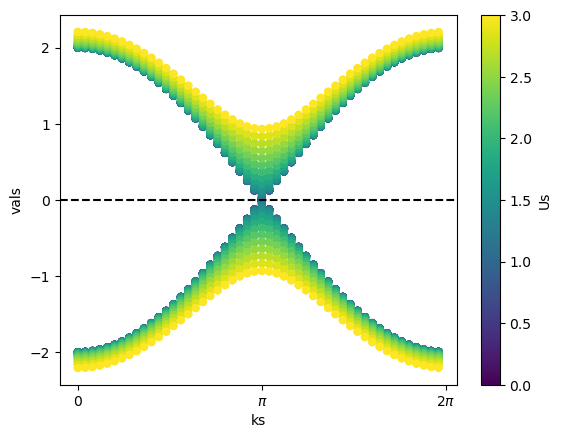

In [16]:
ds.vals.plot.scatter(x='ks', hue='Us', ec=None)
plt.axhline(0, ls='--', c='k')
plt.xticks([0, np.pi, 2 * np.pi], ['$0$', '$\pi$', '$2\pi$'])
plt.show()

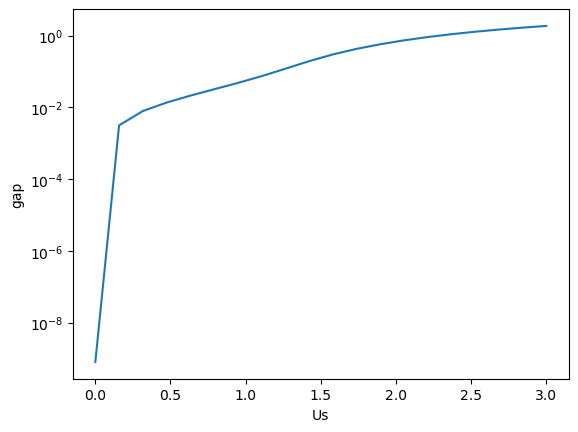

In [17]:
ds.gap.plot()
plt.yscale('log')
plt.show()

In [19]:
ds.to_netcdf('./data/1d_hubbard_example.nc')